In [23]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import html
import re
import string
from bs4 import BeautifulSoup
from tqdm import tqdm
import operator
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import nltk
import plotly.express as px
from sklearn.decomposition import PCA
import warnings
from sklearn.manifold import TSNE
import math
from collections import Counter
from scipy.sparse import coo_matrix, hstack
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from scorer import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVC
%matplotlib inline

nltk.download('wordnet')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lette\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
bodies = pd.read_csv(r"C:\Users\lette\Documents\Learning Materials\Udemy - Complete 2020 Data Science & Machine Learning Bootcamp\Fake_News\fnc-1-master\train_bodies.csv")
stance = pd.read_csv(r"C:\Users\lette\Documents\Learning Materials\Udemy - Complete 2020 Data Science & Machine Learning Bootcamp\Fake_News\fnc-1-master\train_stances.csv")

In [3]:
bodies.rename(columns={"Body ID": "id"},inplace=True)
bodies.head()

,id,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [4]:
stance.rename(columns={"Body ID": "id"},inplace=True)
stance.head()

,Headline,id,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree


In [5]:
# Merging both the datasets
data = pd.merge(stance, bodies, how='left', on='id')
data.head()

,Headline,id,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,1923,disagree,"Fear not arachnophobes, the story of Bunbury's..."


In [6]:
data.rename(columns={"articleBody": "Body"},inplace=True)
data.head()

,Headline,id,Stance,Body
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,1923,disagree,"Fear not arachnophobes, the story of Bunbury's..."


In [7]:
data.reset_index(drop=True, inplace=True)
data.head()

,Headline,id,Stance,Body
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,1923,disagree,"Fear not arachnophobes, the story of Bunbury's..."


# Data Analysis

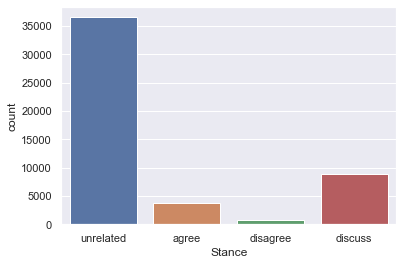

unrelated    36545
discuss       8909
agree         3678
disagree       840
Name: Stance, dtype: int64

In [8]:
sns.set_theme(style="darkgrid");
sns.countplot(data['Stance'])
plt.show()
data['Stance'].value_counts()

In [9]:
# Lets first fix our dependent variable
lables = data['Stance'].unique()
print("Unique Values in our Target Variable before changing\n",lables)
data['Stance'].replace(to_replace='unrelated', value=0,inplace=True)
data['Stance'].replace(to_replace='agree', value=1,inplace=True)
data['Stance'].replace(to_replace='disagree', value=2,inplace=True)
data['Stance'].replace(to_replace='discuss', value=3,inplace=True)
print("\nUnique Values in our Target Variable after the change\n",data['Stance'].unique())

Unique Values in our Target Variable before changing
 ['unrelated' 'agree' 'disagree' 'discuss']

Unique Values in our Target Variable after the change
 [0 1 2 3]


The data we have is highly imbalanced, we might need to sample some

In [10]:
# Lets check for any duplicate entries
data[data.duplicated()].shape

(402, 4)

In [11]:
# Removing Duplicate Entries
data = data[~data.duplicated()]

In [12]:
# There are a lot of characters which is not required, hence we can remove those.
data.head()

,Headline,id,Stance,Body
0,Police find mass graves with at least '15 bodi...,712,0,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,158,1,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",137,0,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,0,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,1923,2,"Fear not arachnophobes, the story of Bunbury's..."


In [13]:
a = []
b = []
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
for i in data['Headline']:
    a.append(decontracted(i))
for i in data['Body']:
    b.append(decontracted(i))
data['Headline'] = pd.DataFrame(a,columns=["Headline"]).values
data['Body'] = pd.DataFrame(b,columns=["Body"]).values

In [14]:
# Cleaning data of links, alphanumeric words, and other non essential elements
stops = {"0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz"}

def clean_text(data):    
    pro_sum = []
    for sentance in tqdm(data.values):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        sentance = html.unescape(sentance)
        sentance = sentance.replace("\\n"," ")
        sentance = sentance.replace("_NEG","")
        sentance = sentance.replace("_NEGFIRST", "")
        sentance = re.sub(r"#", "", sentance)
        sentance = re.sub(r"\*", "", sentance)
        sentance = re.sub(r"\'s", "", sentance)
        sentance = re.sub(r"\'m", " am", sentance)
        sentance = re.sub(r"\'ve", " have", sentance)
        sentance = re.sub(r"n\'t", " not", sentance)
        sentance = re.sub(r"\'re", " are", sentance)
        sentance = re.sub(r"\'d", " would", sentance)
        sentance = re.sub(r"\'ll", " will", sentance)
        sentance = re.sub(r",", "", sentance)
        sentance = re.sub(r"!", " !", sentance)
        sentance = re.sub(r"\(", "", sentance)
        sentance = re.sub(r"\)", "", sentance)
        sentance = re.sub(r"\?", " ?", sentance)
        sentance = re.sub(r'[^\x00-\x7F]',' ', sentance)
        sentance = re.sub(r'[^\w\s]',' ',sentance)
        sentance = re.sub("\d+", " ", sentance)
        sentance = re.sub(r"\s{2,}", " ", sentance)
        sentance = sentance.rstrip(',|.|;|:|\'|\"')
        sentance = sentance.lstrip('\'|\"')
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stops)
        pro_sum.append(sentance.strip())
    return pro_sum
pro_sum = clean_text(data['Headline'])
data['Headline'] = pd.DataFrame(pro_sum,columns=["Headline"]).values
pro_sum = clean_text(data['Body'])
data['Body'] = pd.DataFrame(pro_sum,columns=["Body"]).values

100%|███████████████████████████████████████████████████████████████████████████| 49570/49570 [01:21<00:00, 605.08it/s]


In [15]:
data.dropna(inplace = True)
data.head()

,Headline,id,Stance,Body
0,police mass graves bodies mexico town students...,712,0,danny boyle directing untitled film seth rogen...
1,hundreds palestinians flee floods gaza israel ...,158,1,hundreds palestinians evacuated homes sunday m...
2,christian bale passes role steve jobs actor re...,137,0,moscow resident hospitalized wounds intimate n...
3,hbo apple talks apple streaming service launch...,1034,0,reuters canadian soldier shot canadian war mem...
4,spider burrowed tourist stomach chest,1923,2,fear arachnophobes story bunbury spiderman per...


In [16]:
# Function for Stemming of words
# Snowball Stemming
def stemming_word(data,splitting = True,type_of = "snow"):
    if type_of.lower() == "snow":
        stemmer = SnowballStemmer('english')
        a = []
        if splitting == True:
            a = data.apply(lambda x: [stemmer.stem(y) for y in x.split()])
            a = a.str.join(" ")
        else:
            a = data.apply(lambda k: [stemmer.stem(y) for y in k])
            a = a.str.join("")
        return a
    if type_of.lower() == "porter":
        stemmer = PorterStemmer()
        a = []
        if splitting == True:
            a = data.apply(lambda x: [stemmer.stem(y) for y in x.split()])
            a = a.str.join(" ")
        else:
            a = data.apply(lambda k: [stemmer.stem(y) for y in k])
            a = a.str.join("")
        return a
    if type_of.lower()=="lemm":
        lem = WordNetLemmatizer()
        a = []
        if splitting == True:
            a = data.apply(lambda x: [lem.lemmatize(y) for y in x.split()])
            a = a.str.join(" ")
        else:
            a = data.apply(lambda k: [lem.lemmatize(y) for y in k])
            a = a.str.join("")
        return a
    else:
        print("Plese Select the mentioned Options for 'type_of' field:\n")
        print("1>'Snow': SnowballStemmer\n2>'Porter':PorterStemmer\n3>'Lemm':WordNetLemmatizer")

In [17]:
# Creating a function that returns the vectorized value when it is called
def text_to_numbers(data,model='BOW',gram=1,feat_names=False):
    if model.lower()=='bow':
        vectorizer = CountVectorizer(ngram_range=(1, gram))
        x = vectorizer.fit_transform(data)
        if feat_names==True:
            count_list = x.toarray().sum(axis=0)
            word_freq = dict(zip(vectorizer.get_feature_names(),count_list))
            return word_freq
        else:
            return x
    if model.lower()=='tfidf':
        vectorizer = TfidfVectorizer()
        x = vectorizer.fit_transform(data)
        if feat_names== True:
            count_list = x.toarray().sum(axis=0)
            word_freq = dict(zip(vectorizer.get_feature_names(),count_list))
            return word_freq
        else:
            return x
    else:
        print("Please enter: \n'model':\n 'BOW': Bag of Words\n 'TFIDF':TF-IDF\n'gram' for N_Gram: mention a nunber(Between 1-4) if 'BOW'is closen\n")
        print("If you want the feature names, please make 'feat_names' as true\nThis would only return the geature names")

In [18]:
# Create WordClould to check the difference between Spam and Ham Emails.
def word_cloud(data,model = "BOW",gram=1,n_words=100,title1="WordCloud"):
    word_freq = text_to_numbers(data,model,gram,feat_names=True)
    features_freq = dict(sorted(word_freq.items(),key=operator.itemgetter(1),reverse=True))
    cloud = list({A:N for (A,N) in [x for x in features_freq.items()][:n_words]}.keys())
    wordcloud = WordCloud(width = 4000, height = 1000, 
                background_color ='black', min_font_size = 10).generate(" ".join(cloud))
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.title(title1, fontsize=1)
    plt.imshow(wordcloud,interpolation="bilinear") 
    plt.axis("off")
    plt.show()

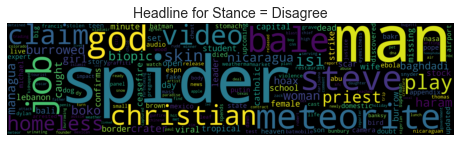

In [23]:
# Lets check how the Headline words looks like for Headline where Stance is Disagree
snow_head = stemming_word(data[data.Stance==2]['Headline'],splitting = True,type_of = "lemm")
word_cloud(snow_head,model = "BOW",gram=1,n_words=200,title1="Headline for Stance = Disagree")

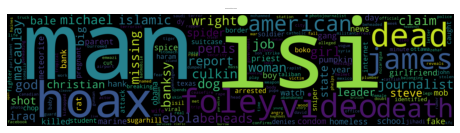

In [27]:
# Lets check how the Headline words looks like for Headline where Stance is agree
snow_head = stemming_word(data[data.Stance==1]['Headline'],splitting = True,type_of = "lemm")
word_cloud(snow_head,model = "BOW",gram=1,n_words=200,title1="Headline for Stance = agree")

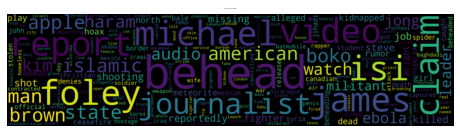

In [28]:
# Lets check how the Headline words looks like for Headline where Stance is unrelated
# ['unrelated' 'agree' 'disagree' 'discuss']
snow_head = stemming_word(data[data.Stance==0]['Headline'],splitting = True,type_of = "lemm")
word_cloud(snow_head,model = "BOW",gram=1,n_words=200,title1="Headline for Stance = Disagree")

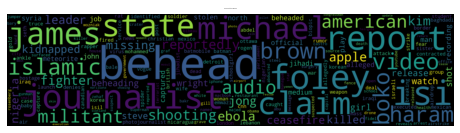

In [31]:
# Lets check how the Headline words looks like for Headline where Stance is discuss
# ['unrelated' 'agree' 'disagree' 'discuss']
snow_head = stemming_word(data[data.Stance==3]['Headline'],splitting = True,type_of = "lemm")
word_cloud(snow_head,model = "BOW",gram=1,n_words=200,title1="Headline for Stance = Disagree")

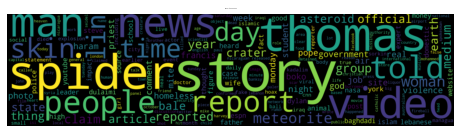

In [32]:
# Similarly lets check for 
# Lets check how the Body words looks like for Headline where Stance is Disagree
snow_head = stemming_word(data[data.Stance==2]['Body'],splitting = True,type_of = "lemm")
word_cloud(snow_head,model = "BOW",gram=1,n_words=200,title1="Body for Stance = Disagree")

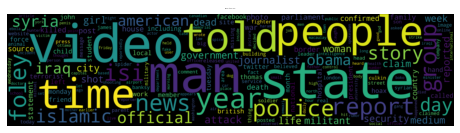

In [33]:
# Lets check how the Body words looks like for Headline where Stance is agree
snow_head = stemming_word(data[data.Stance==1]['Body'],splitting = True,type_of = "lemm")
word_cloud(snow_head,model = "BOW",gram=1,n_words=200,title1="Body for Stance = agree")

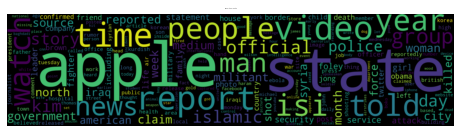

In [34]:
# Lets check how the Headline words looks like for Headline where Stance is unrelated
# ['unrelated' 'agree' 'disagree' 'discuss']
snow_head = stemming_word(data[data.Stance==0]['Body'],splitting = True,type_of = "lemm")
word_cloud(snow_head,model = "BOW",gram=1,n_words=200,title1="Body for Stance = unrelated")

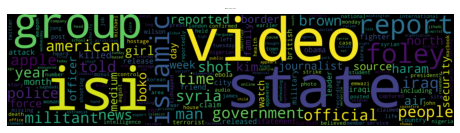

In [35]:
# ['unrelated' 'agree' 'disagree' 'discuss']
snow_head = stemming_word(data[data.Stance==3]['Body'],splitting = True,type_of = "lemm")
word_cloud(snow_head,model = "BOW",gram=1,n_words=200,title1="Body for Stance = discuss")

From the word cloud we could see that apart from a few words relating to the "News" there is some significant difference between class labels.<br>Lets now see how well can our data be separable through TSNE.

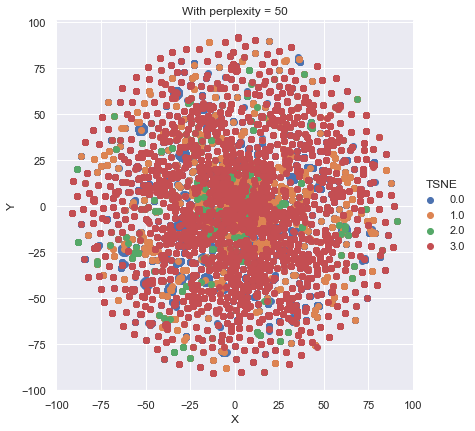

In [42]:
# TSNE on BagOfWords Model
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
corpus = stemming_word(data['Body'],splitting = True,type_of = "lemm")
corpus = text_to_numbers(corpus,model='BOW',gram=1,feat_names=False)
tsne_data = tsne.fit_transform(corpus)

tsne_data = np.vstack((tsne_data.T, data['Stance'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("X", "Y", "TSNE"))

sns.FacetGrid(tsne_df, hue="TSNE", size=6).map(plt.scatter, 'X', 'Y').add_legend()
plt.title('With perplexity = 30')
plt.show()

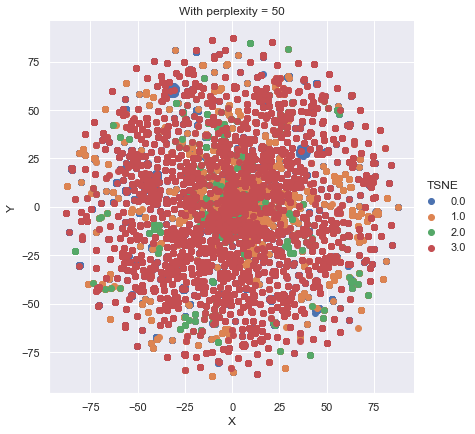

In [44]:
tsne = TSNE(n_components=2, perplexity=50, random_state=0)
corpus = stemming_word(data['Body'],splitting = True,type_of = "lemm")
corpus = text_to_numbers(corpus,model='BOW',gram=1,feat_names=False)
tsne_data = tsne.fit_transform(corpus)

tsne_data = np.vstack((tsne_data.T, data['Stance'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("X", "Y", "TSNE"))

sns.FacetGrid(tsne_df, hue="TSNE", size=6).map(plt.scatter, 'X', 'Y').add_legend()
plt.title('With perplexity = 50')
plt.show()

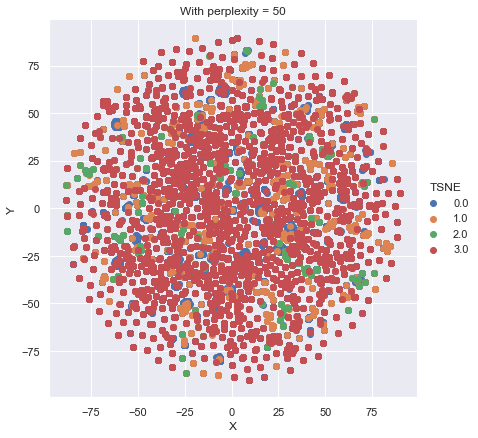

In [48]:
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
corpus = stemming_word(data['Body'],splitting = True,type_of = "lemm")
corpus = text_to_numbers(corpus,model='tfidf',gram=1,feat_names=False)
tsne_data = tsne.fit_transform(corpus)

tsne_data = np.vstack((tsne_data.T, data['Stance'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("X", "Y", "TSNE"))

sns.FacetGrid(tsne_df, hue="TSNE", size=6).map(plt.scatter, 'X', 'Y').add_legend()
plt.title('With perplexity = 50')
plt.show()

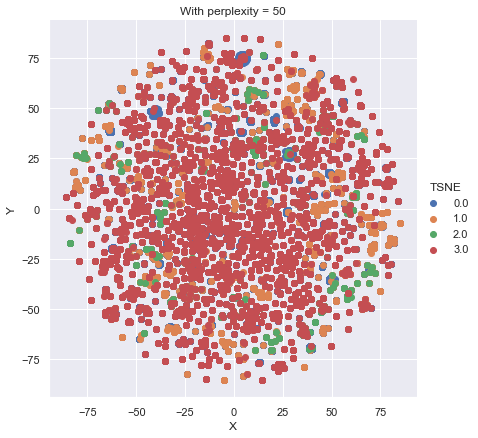

In [49]:
tsne = TSNE(n_components=2, perplexity=50, random_state=0)
corpus = stemming_word(data['Body'],splitting = True,type_of = "lemm")
corpus = text_to_numbers(corpus,model='tfidf',gram=1,feat_names=False)
tsne_data = tsne.fit_transform(corpus)

tsne_data = np.vstack((tsne_data.T, data['Stance'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("X", "Y", "TSNE"))

sns.FacetGrid(tsne_df, hue="TSNE", size=6).map(plt.scatter, 'X', 'Y').add_legend()
plt.title('With perplexity = 50')
plt.show()

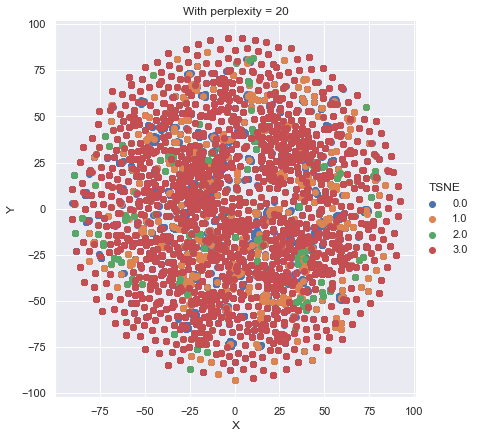

In [50]:
tsne = TSNE(n_components=2, perplexity=20, random_state=0)
corpus = stemming_word(data['Body'],splitting = True,type_of = "lemm")
corpus = text_to_numbers(corpus,model='tfidf',gram=1,feat_names=False)
tsne_data = tsne.fit_transform(corpus)

tsne_data = np.vstack((tsne_data.T, data['Stance'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("X", "Y", "TSNE"))

sns.FacetGrid(tsne_df, hue="TSNE", size=6).map(plt.scatter, 'X', 'Y').add_legend()
plt.title('With perplexity = 20')
plt.show()

# Modeling<br>
From here we would start designing our model and check how well it helps us in identifying fake news.

In [19]:
# Will first try with only the texts from Headline and Body, next we would try with adding new features
def join_sparse(mat1,mat2):
    return hstack([mat1,mat2])
def train_data(body,headline,y):
    X = join_sparse(headline,body)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    return X_train, X_test, y_train, y_test

In [20]:
def validate_result(y_true, y_pred,model="Model"):
    print(f"The Result for the {model} Classification is a Below\n")
    conf = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
# the size of A4 paper
    fig.set_size_inches(9, 9)
    b = sns.heatmap(conf, cmap="YlGnBu",annot=True,ax=ax)
    b.axes.set_title("Confusion Matrix",fontsize=20)
    b.set_xlabel("Predicted Value",fontsize=16)
    b.set_ylabel("True Value",fontsize=16)
    b.tick_params(labelsize=16)
    print("=="*50)
    print(f"Recall Score: {recall_score(y_true, y_pred,average='weighted')*100} %")
    print(f"Precision Score: {precision_score(y_true, y_pred,average='weighted')*100} %")
    print("F1 Score: ",f1_score(y_true, y_pred,average='weighted'))
    #print("Log Loss: ",log_loss(y_true, y_pred))
    print(f"Accuracy: {accuracy_score(y_true,y_pred)*100} %")
    report = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
    print("Classification Report:\n",df)

The Result for the Multinomial Naive Bayes Classification is a Below

Recall Score: 47.69685965974044 %
Precision Score: 73.04787485124115 %
F1 Score:  0.531071854009319
Accuracy:  0.47696859659740437
Classification Report:
               precision    recall  f1-score       support
0              0.886462  0.432006  0.580912  10898.000000
1              0.184083  0.507150  0.270119   1049.000000
2              0.075508  0.666667  0.135652    234.000000
3              0.368593  0.630855  0.465314   2690.000000
accuracy       0.476969  0.476969  0.476969      0.476969
macro avg      0.378661  0.559169  0.362999  14871.000000
weighted avg   0.730479  0.476969  0.531072  14871.000000


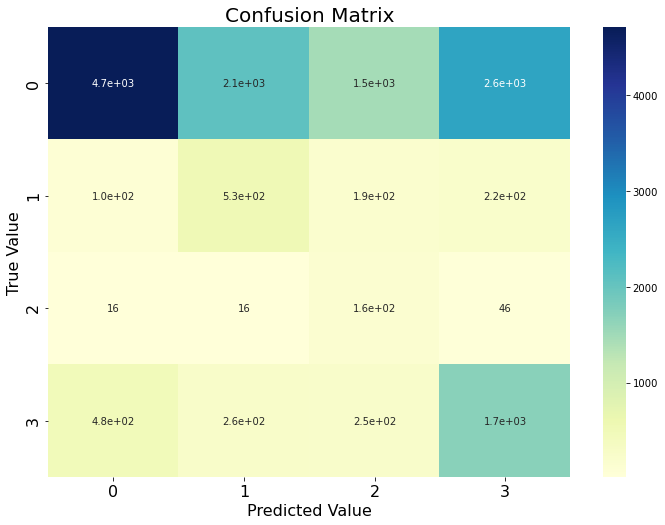

In [48]:
# Prepairing a Baseline model
from sklearn.naive_bayes import MultinomialNB
body = text_to_numbers(data['Body'],model='BOW',gram=1,feat_names=False)
headline = text_to_numbers(data['Body'],model='BOW',gram=1,feat_names=False)
y = data['Stance']
X_train, X_cv, y_train, y_cv = train_data(body,headline,y)
clf = MultinomialNB()
clf.fit(X_train, y_train)
validate_result(y_cv,clf.predict(X_cv),model="Multinomial Naive Bayes",clf = clf)

The Result for the Multinomial Naive Bayes Classification is a Below

Recall Score: 75.32781924551139 %
Precision Score: 73.66186696606711 %
F1 Score:  0.7402602004334085
Accuracy:  0.753278192455114
Classification Report:
               precision    recall  f1-score       support
0              0.827688  0.874472  0.850437  10898.000000
1              0.446541  0.203051  0.279161   1049.000000
2              0.404762  0.145299  0.213836    234.000000
3              0.509657  0.529740  0.519504   2690.000000
accuracy       0.753278  0.753278  0.753278      0.753278
macro avg      0.547162  0.438140  0.465735  14871.000000
weighted avg   0.736619  0.753278  0.740260  14871.000000


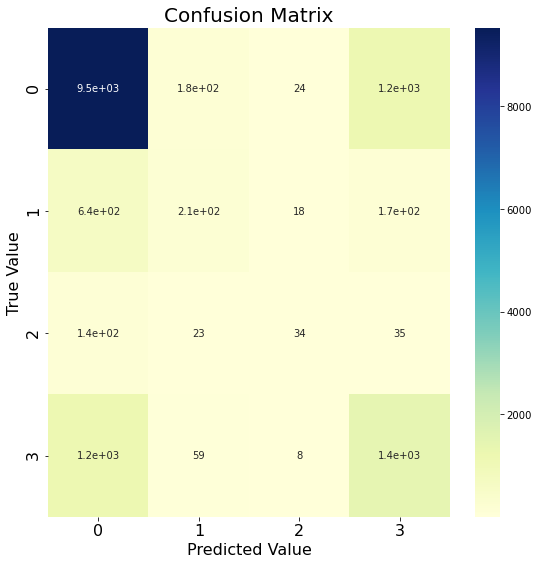

In [55]:
# Prepairing a Baseline model
body = stemming_word(data['Body'],splitting = True,type_of = "snow")
headline = stemming_word(data['Headline'],splitting = True,type_of = "snow")
body = text_to_numbers(body,model='tfidf',gram=1,feat_names=False)
headline = text_to_numbers(headline,model='tfidf',gram=1,feat_names=False)
y = data['Stance']
X_train, X_cv, y_train, y_cv = train_data(body,headline,y)
clf = MultinomialNB()
clf.fit(X_train, y_train)
validate_result(y_cv,clf.predict(X_cv),model="Multinomial Naive Bayes",clf = clf)

The Result for the Multinomial Naive Bayes Classification is a Below

Recall Score: 75.32109474816757 %
Precision Score: 73.63341136093743 %
F1 Score:  0.7401382484690661
Accuracy:  0.7532109474816757
Classification Report:
               precision    recall  f1-score       support
0              0.827832  0.874472  0.850513  10898.000000
1              0.441176  0.200191  0.275410   1049.000000
2              0.400000  0.145299  0.213166    234.000000
3              0.510007  0.530483  0.520044   2690.000000
accuracy       0.753211  0.753211  0.753211      0.753211
macro avg      0.544754  0.437611  0.464783  14871.000000
weighted avg   0.736334  0.753211  0.740138  14871.000000


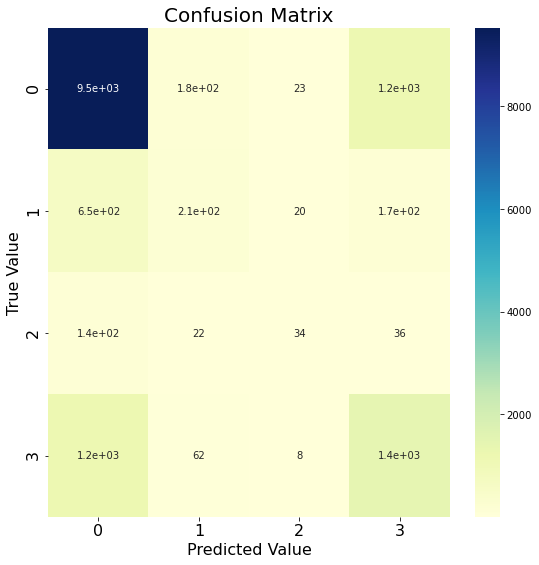

In [57]:
# Prepairing a Baseline model
body = stemming_word(data['Body'],splitting = True,type_of = "porter")
headline = stemming_word(data['Headline'],splitting = True,type_of = "porter")
body = text_to_numbers(body,model='tfidf',gram=1,feat_names=False)
headline = text_to_numbers(headline,model='tfidf',gram=1,feat_names=False)
y = data['Stance']
X_train, X_cv, y_train, y_cv = train_data(body,headline,y)
clf = MultinomialNB()
clf.fit(X_train, y_train)
validate_result(y_cv,clf.predict(X_cv),model="Multinomial Naive Bayes",clf = clf)

----precision--recall--f1-score      
0----0.827832  0.874472  0.850513  
1----0.441176  0.200191  0.275410   
2----0.400000  0.145299  0.213166    
3----0.510007  0.530483  0.520044  
We could find that the class with less amount of data is performing worst.
Hence lets try balancing the data and try out our same baseline models, to get a better idea

In [26]:
# This function would return samples variables, i have used 4 different options of sampling in this case.
# Would try modelling on all the 4 sampled data and check which one performs better.
def sampling_data(X,y,option="SMOTE",strategy = "auto"):
    if option.lower()=="smote":
        smo = SMOTE(random_state=52,sampling_strategy = strategy)
        smo.fit(X, y)
        X_resampled, y_resampled = smo.fit_sample(X, y)
    elif option.lower()=="under":
        rus = RandomUnderSampler(random_state=42,sampling_strategy = strategy)
        rus.fit(X, y)
        X_resampled, y_resampled = rus.fit_sample(X, y)
    elif option.lower()=="over":
        ros = RandomOverSampler(random_state=42,sampling_strategy = strategy)
        ros.fit(X, y)
        X_resampled, y_resampled = ros.fit_sample(X, y)
    elif option.lower()=="near":
        near = NearMiss(sampling_strategy = strategy)
        near.fit(X, y)
        X_resampled, y_resampled = near.fit_sample(X, y)
    else:
        print("Please select from the below options: ")
        print("1: Under || 2: Over || 3: Near || 4. SMOTE")
    return X_resampled,y_resampled

The Result for the Multinomial Naive Bayes with UnderSampling Classification is a Below

Recall Score: 38.538094277452764 %
Precision Score: 70.56814085708928 %
F1 Score:  0.42545905788574084
Accuracy: 38.538094277452764 %
Classification Report:
               precision    recall  f1-score       support
0              0.873372  0.307579  0.454940  10898.000000
1              0.166667  0.392755  0.234024   1049.000000
2              0.068096  0.692308  0.123995    234.000000
3              0.291977  0.671004  0.406898   2690.000000
accuracy       0.385381  0.385381  0.385381      0.385381
macro avg      0.350028  0.515911  0.304965  14871.000000
weighted avg   0.705681  0.385381  0.425459  14871.000000


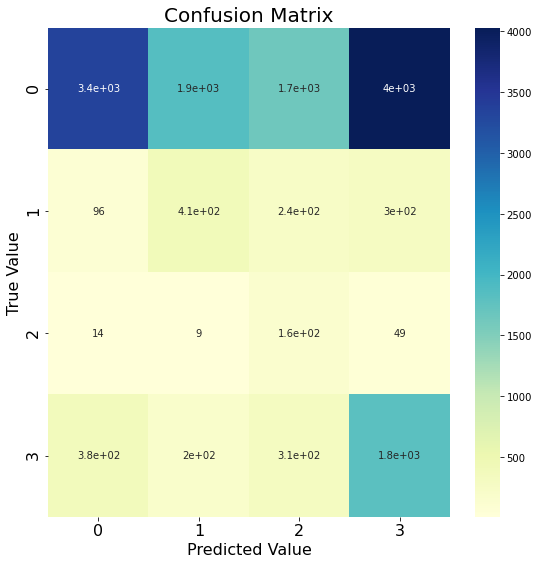

In [71]:
# Prepairing a Baseline model
body = stemming_word(data['Body'],splitting = True,type_of = "snow")
headline = stemming_word(data['Headline'],splitting = True,type_of = "snow")
body = text_to_numbers(body,model='tfidf',gram=1,feat_names=False)
headline = text_to_numbers(headline,model='tfidf',gram=1,feat_names=False)
y = data['Stance']
X_train, X_cv, y_train, y_cv = train_data(body,headline,y)
X_train,y_train = sampling_data(X_train,y_train,option="under",strategy = "auto")
clf = MultinomialNB()
clf.fit(X_train, y_train)
validate_result(y_cv,clf.predict(X_cv),model="Multinomial Naive Bayes with UnderSampling")

The Result for the Multinomial Naive Bayes with UnderSampling Classification is a Below

Recall Score: 56.29076726514693 %
Precision Score: 76.23508265190135 %
F1 Score:  0.6102907795091292
Accuracy:  0.5629076726514693
Classification Report:
               precision    recall  f1-score       support
0              0.920499  0.534410  0.676226  10898.000000
1              0.210421  0.500477  0.296275   1049.000000
2              0.126611  0.713675  0.215068    234.000000
3              0.392178  0.689591  0.500000   2690.000000
accuracy       0.562908  0.562908  0.562908      0.562908
macro avg      0.412427  0.609538  0.421892  14871.000000
weighted avg   0.762351  0.562908  0.610291  14871.000000


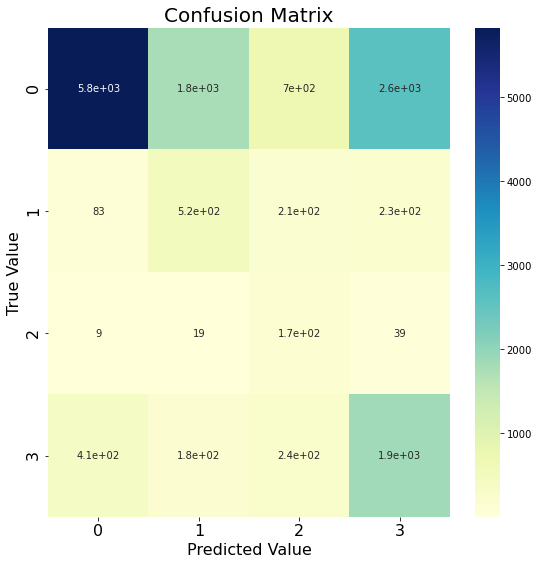

In [66]:
# Prepairing a Baseline model
body = stemming_word(data['Body'],splitting = True,type_of = "porter")
headline = stemming_word(data['Headline'],splitting = True,type_of = "porter")
body = text_to_numbers(body,model='tfidf',gram=1,feat_names=False)
headline = text_to_numbers(headline,model='tfidf',gram=1,feat_names=False)
y = data['Stance']
X_train, X_cv, y_train, y_cv = train_data(body,headline,y)
X_train,y_train = sampling_data(X_train,y_train,option="over",strategy = "auto")
clf = MultinomialNB()
clf.fit(X_train, y_train)
validate_result(y_cv,clf.predict(X_cv),model="Multinomial Naive Bayes with UnderSampling")

The Result for the Multinomial Naive Bayes with UnderSampling Classification is a Below

Recall Score: 54.74413287606751 %
Precision Score: 60.65119302986246 %
F1 Score:  0.5734622869473492
Accuracy:  0.5474413287606752
Classification Report:
               precision    recall  f1-score       support
0              0.742684  0.663700  0.700974  10898.000000
1              0.154793  0.167779  0.161025   1049.000000
2              0.046061  0.324786  0.080679    234.000000
3              0.279744  0.243866  0.260576   2690.000000
accuracy       0.547441  0.547441  0.547441      0.547441
macro avg      0.305821  0.350033  0.300814  14871.000000
weighted avg   0.606512  0.547441  0.573462  14871.000000


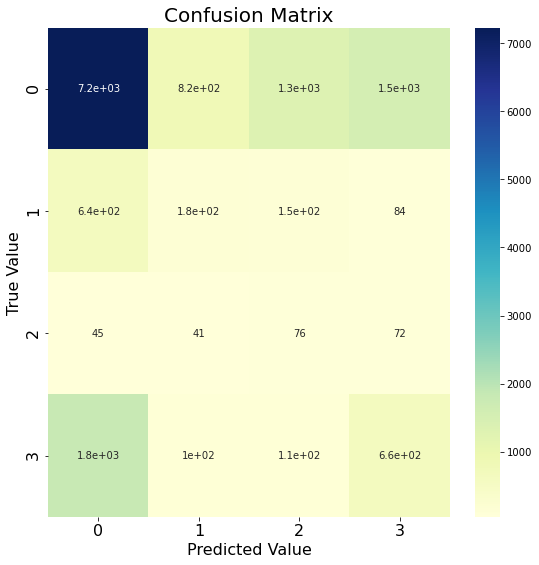

In [68]:
# Prepairing a Baseline model
body = stemming_word(data['Body'],splitting = True,type_of = "porter")
headline = stemming_word(data['Headline'],splitting = True,type_of = "porter")
body = text_to_numbers(body,model='tfidf',gram=1,feat_names=False)
headline = text_to_numbers(headline,model='tfidf',gram=1,feat_names=False)
y = data['Stance']
X_train, X_cv, y_train, y_cv = train_data(body,headline,y)
X_train,y_train = sampling_data(X_train,y_train,option="near",strategy = "auto")
clf = MultinomialNB()
clf.fit(X_train, y_train)
validate_result(y_cv,clf.predict(X_cv),model="Multinomial Naive Bayes with UnderSampling")

The Result for the Multinomial Naive Bayes with UnderSampling Classification is a Below

Recall Score: 56.378185730616636 %
Precision Score: 75.92638034683378 %
F1 Score:  0.6109016974124937
Accuracy:  0.5637818573061664
Classification Report:
               precision    recall  f1-score       support
0              0.916302  0.537438  0.677501  10898.000000
1              0.214717  0.509056  0.302036   1049.000000
2              0.124713  0.696581  0.211551    234.000000
3              0.390608  0.680297  0.496271   2690.000000
accuracy       0.563782  0.563782  0.563782      0.563782
macro avg      0.411585  0.605843  0.421840  14871.000000
weighted avg   0.759264  0.563782  0.610902  14871.000000


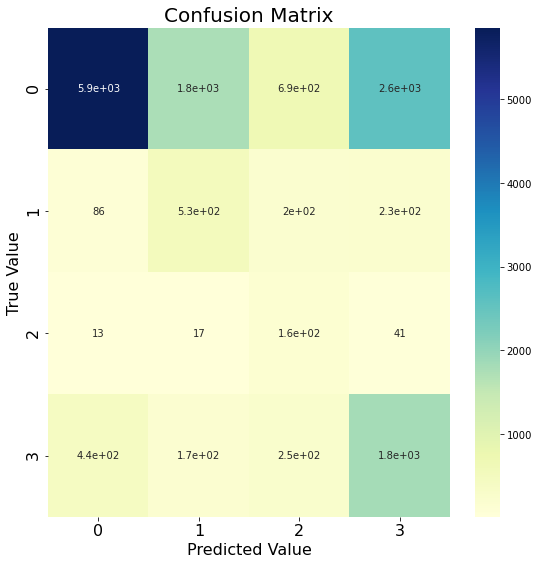

In [69]:
X_train, X_cv, y_train, y_cv = train_data(body,headline,y)
X_train,y_train = sampling_data(X_train,y_train,option="smote",strategy = "auto")
clf = MultinomialNB()
clf.fit(X_train, y_train)
validate_result(y_cv,clf.predict(X_cv),model="Multinomial Naive Bayes with UnderSampling")

# Sampled data is performing very bad in our Cross Validation. So now lets try a different model
These is our baseline scores:<br>
Recall Score: 75.32109474816757 %<br>
Precision Score: 73.63341136093743 %<br>
Accuracy Score: ~ 75%<br>

In [21]:
body = stemming_word(data['Body'],splitting = True,type_of = "snow")
headline = stemming_word(data['Headline'],splitting = True,type_of = "snow")
body = text_to_numbers(body,model='tfidf',gram=1,feat_names=False)
headline = text_to_numbers(headline,model='tfidf',gram=1,feat_names=False)
y = data['Stance']
X_train, X_cv, y_train, y_cv = train_data(body,headline,y)

The Result for the Logistic Regression with SGD Classifier Classification is a Below

Recall Score: 77.48638289287875 %
Precision Score: 78.20961764256018 %
F1 Score:  0.7125234827517132
Accuracy: 77.48638289287875 %
Classification Report:
               precision    recall  f1-score       support
0              0.773171  0.988989  0.867864  10898.000000
1              0.783784  0.027645  0.053407   1049.000000
2              1.000000  0.042735  0.081967    234.000000
3              0.798643  0.262454  0.395076   2690.000000
accuracy       0.774864  0.774864  0.774864      0.774864
macro avg      0.838899  0.330456  0.349578  14871.000000
weighted avg   0.782096  0.774864  0.712523  14871.000000


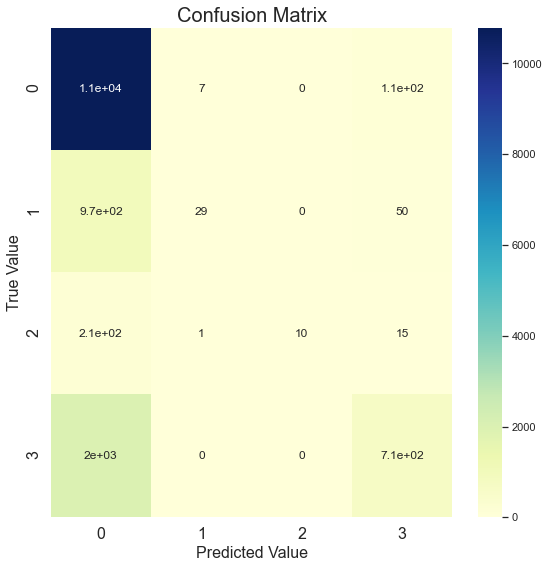

In [25]:
# Lets check how Logistic regression works with our model
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='log',early_stopping=True, validation_fraction=0.2)
clf.fit(X_train,y_train)
validate_result(y_cv,clf.predict(X_cv),model="Logistic Regression with SGD Classifier")

The Result for the Logistic Regression with SGD Classifier Classification is a Below

Recall Score: 61.81830408176987 %
Precision Score: 78.93407464853885 %
F1 Score:  0.6570926804578575
Accuracy: 61.818304081769895 %
Classification Report:
               precision    recall  f1-score       support
0              0.933818  0.577445  0.713613  10898.000000
1              0.270947  0.712107  0.392538   1049.000000
2              0.176786  0.846154  0.292467    234.000000
3              0.459459  0.726766  0.562995   2690.000000
accuracy       0.618183  0.618183  0.618183      0.618183
macro avg      0.460252  0.715618  0.490403  14871.000000
weighted avg   0.789341  0.618183  0.657093  14871.000000


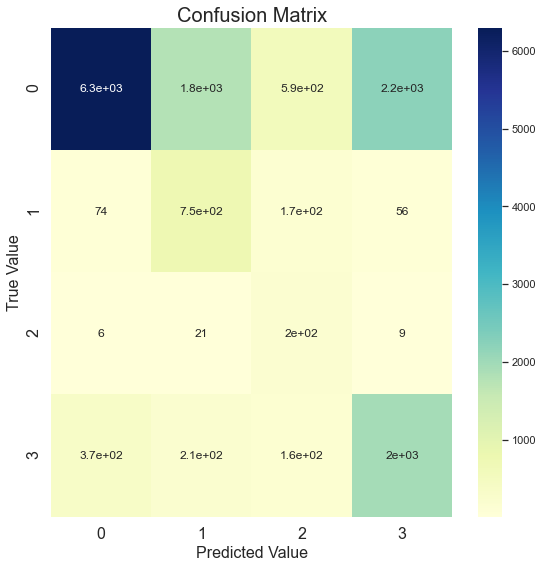

In [32]:
# It is Intresting to see that our Class Lable 2 is heavily been misclassified as 0.
# This means that the classes whcih have very less data are much more prone to misclassification.
# Lets try some sampling technique
X_train1,y_train1 = sampling_data(X_train,y_train,option="over",strategy = "auto")
clf = SGDClassifier(loss='log',early_stopping=True, validation_fraction=0.2)
clf.fit(X_train1,y_train1)
validate_result(y_cv,clf.predict(X_cv),model="Logistic Regression with SGD Classifier")

The Result for the Logistic Regression with SGD Classifier Classification is a Below

Recall Score: 48.25499293927779 %
Precision Score: 71.21499615108604 %
F1 Score:  0.5256194348458996
Accuracy: 48.25499293927779 %
Classification Report:
               precision    recall  f1-score      support
0              0.864006  0.429070  0.573391  10898.00000
1              0.195300  0.586273  0.292997   1049.00000
2              0.133515  0.837607  0.230317    234.00000
3              0.348823  0.627881  0.448486   2690.00000
accuracy       0.482550  0.482550  0.482550      0.48255
macro avg      0.385411  0.620208  0.386298  14871.00000
weighted avg   0.712150  0.482550  0.525619  14871.00000


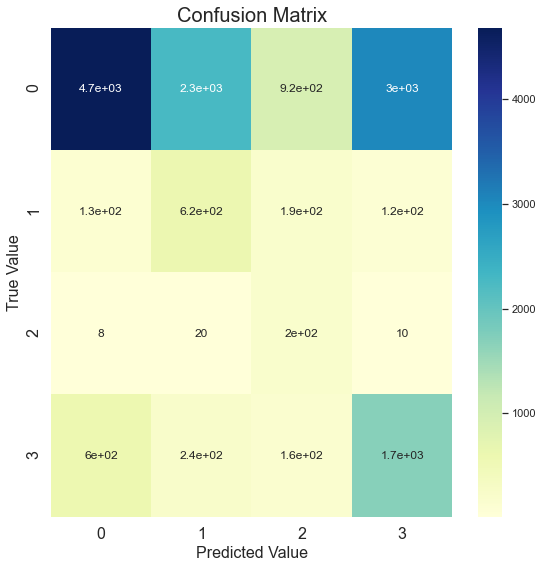

In [33]:
# Over Sampling improves the recall for the classed with less datapoints, but Class 0 is being misclassified heavily.
# Let us try some different sampling technique
X_train1,y_train1 = sampling_data(X_train,y_train,option="under",strategy = "auto")
clf = SGDClassifier(loss='log',early_stopping=True, validation_fraction=0.2)
clf.fit(X_train1,y_train1)
validate_result(y_cv,clf.predict(X_cv),model="Logistic Regression with SGD Classifier")

The Result for the Logistic Regression with SGD Classifier Classification is a Below

Recall Score: 63.028713603658126 %
Precision Score: 78.58413602875711 %
F1 Score:  0.6680201265411977
Accuracy: 63.028713603658126 %
Classification Report:
               precision    recall  f1-score       support
0              0.926961  0.599743  0.728286  10898.000000
1              0.276620  0.708294  0.397858   1049.000000
2              0.182517  0.811966  0.298039    234.000000
3              0.465184  0.707807  0.561404   2690.000000
accuracy       0.630287  0.630287  0.630287      0.630287
macro avg      0.462820  0.706952  0.496397  14871.000000
weighted avg   0.785841  0.630287  0.668020  14871.000000


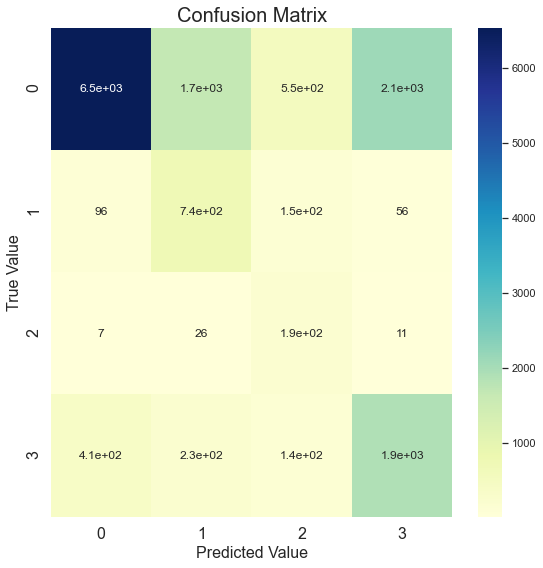

In [34]:
# Lets try a SMOTE
X_train1,y_train1 = sampling_data(X_train,y_train,option="smote",strategy = "auto")
clf = SGDClassifier(loss='log',early_stopping=True, validation_fraction=0.2)
clf.fit(X_train1,y_train1)
validate_result(y_cv,clf.predict(X_cv),model="Logistic Regression with SGD Classifier")

The Result for the Logistic Regression with SGD Classifier Classification is a Below

Recall Score: 60.62134355456929 %
Precision Score: 63.47466629891992 %
F1 Score:  0.6158705756274644
Accuracy: 60.62134355456929 %
Classification Report:
               precision    recall  f1-score       support
0              0.759175  0.732703  0.745704  10898.000000
1              0.177903  0.181125  0.179499   1049.000000
2              0.113755  0.653846  0.193794    234.000000
3              0.354124  0.255390  0.296760   2690.000000
accuracy       0.606213  0.606213  0.606213      0.606213
macro avg      0.351239  0.455766  0.353939  14871.000000
weighted avg   0.634747  0.606213  0.615871  14871.000000


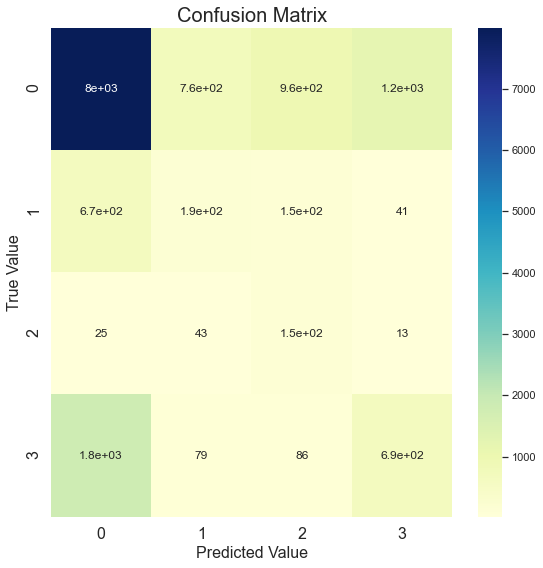

In [35]:
# Near Miss
X_train1,y_train1 = sampling_data(X_train,y_train,option="near",strategy = "auto")
clf = SGDClassifier(loss='log',early_stopping=True, validation_fraction=0.2)
clf.fit(X_train1,y_train1)
validate_result(y_cv,clf.predict(X_cv),model="Logistic Regression with SGD Classifier")

Although Sampling helps in class labels 2 but misclassified heavily on the other classes.

In [47]:

param = {'penalty':["l1","l2","elasticnet"],"C":[0.0001,0.001,0.01,0.1,1,10,100],
         "solver":['liblinear','sag','saga','lbfgs','newton-cg']}
logistic = LogisticRegression(random_state=0)
clf = RandomizedSearchCV(logistic, param,random_state=0)
clf.fit(X_train, y_train)

RandomizedSearchCV(estimator=LogisticRegression(random_state=0),
                   param_distributions={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                              100],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['liblinear', 'sag', 'saga',
                                                   'lbfgs', 'newton-cg']},
                   random_state=0)

The Result for the Logistic Regression Classification is a Below

Recall Score: 81.54797928854818 %
Precision Score: 80.46989512483529 %
F1 Score:  0.7889818390566793
Accuracy: 81.54797928854818 %
Classification Report:
               precision    recall  f1-score      support
0              0.824939  0.969444  0.891373  10898.00000
1              0.722527  0.250715  0.372258   1049.00000
2              0.645161  0.170940  0.270270    234.00000
3              0.768620  0.468030  0.581793   2690.00000
accuracy       0.815480  0.815480  0.815480      0.81548
macro avg      0.740312  0.464782  0.528923  14871.00000
weighted avg   0.804699  0.815480  0.788982  14871.00000
Log Loss: 50.262307531068 %


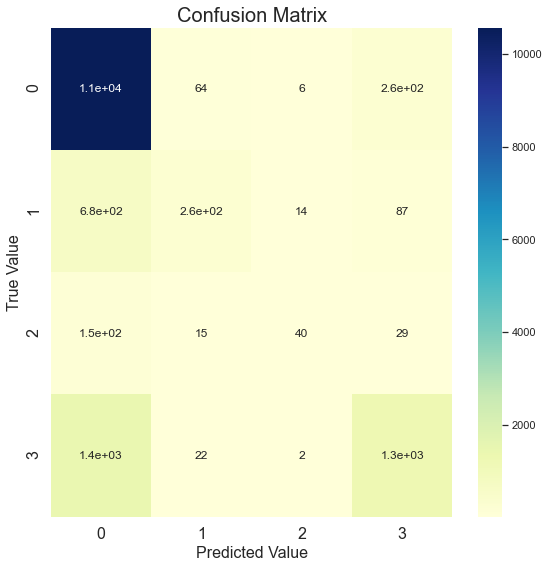

In [48]:
logistic_best = clf.best_estimator_
logistic_best.fit(X_train,y_train)
validate_result(y_cv,logistic_best.predict(X_cv),model="Logistic Regression")
print(f"Log Loss: {log_loss(y_cv,logistic_best.predict_proba(X_cv))*100} %")

In [45]:
# There is a very high improvemetn in Precision adn Recall, but still the Class 1,2 and Class 3 are heavily  missclassified

The Result for the SVM with SGD Classifier Classification is a Below

Recall Score: 79.88030394727994 %
Precision Score: 79.11426885286771 %
F1 Score:  0.7579409943867094
Accuracy: 79.88030394727994 %
Classification Report:
               precision    recall  f1-score       support
0              0.802203  0.982474  0.883234  10898.000000
1              0.747475  0.141087  0.237370   1049.000000
2              0.630435  0.123932  0.207143    234.000000
3              0.777344  0.369888  0.501259   2690.000000
accuracy       0.798803  0.798803  0.798803      0.798803
macro avg      0.739364  0.404345  0.457251  14871.000000
weighted avg   0.791143  0.798803  0.757941  14871.000000


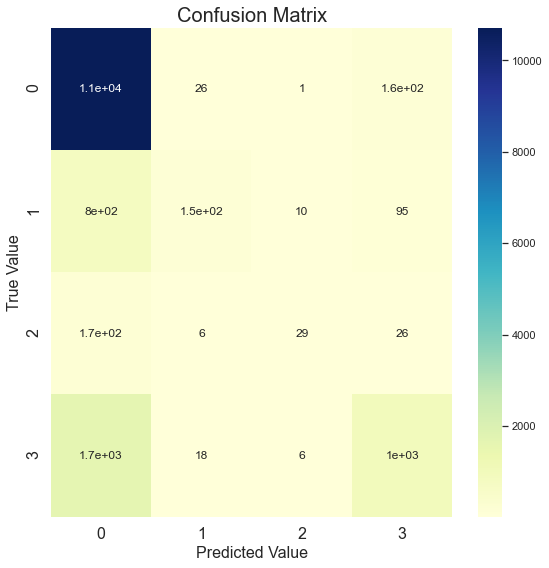

In [36]:
# Lets try SVMClassification
clf = SGDClassifier(early_stopping=True, validation_fraction=0.2)
clf.fit(X_train,y_train)
validate_result(y_cv,clf.predict(X_cv),model="SVM with SGD Classifier")

The Result for the Linear SVM Regression Classification is a Below

Recall Score: 84.54710510389349 %
Precision Score: 83.78473548771201 %
F1 Score:  0.8348405487109797
Accuracy: 84.54710510389349 %
Classification Report:
               precision    recall  f1-score       support
0              0.863101  0.955129  0.906786  10898.000000
1              0.698241  0.491897  0.577181   1049.000000
2              0.562092  0.367521  0.444444    234.000000
3              0.813966  0.580669  0.677804   2690.000000
accuracy       0.845471  0.845471  0.845471      0.845471
macro avg      0.734350  0.598804  0.651554  14871.000000
weighted avg   0.837847  0.845471  0.834841  14871.000000


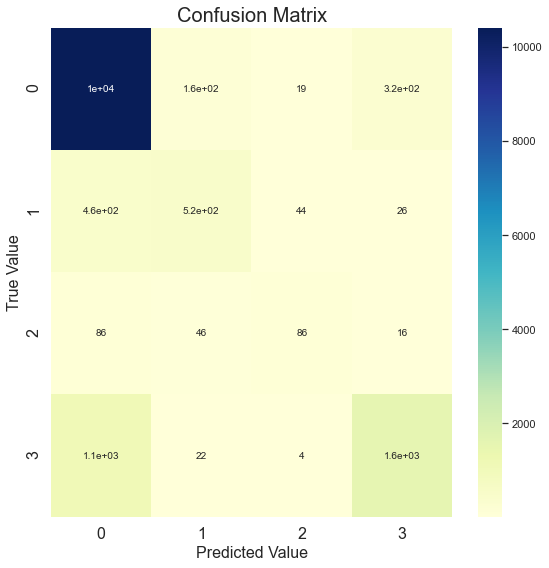

In [24]:
# Lets try SVM
param = {'penalty':["l1","l2"],"C":[0.0001,0.001,0.01,0.1,1,10,100]}
lin_svc = LinearSVC(random_state=0)
clf = RandomizedSearchCV(lin_svc, param,random_state=0)
clf.fit(X_train, y_train)
lin_best = clf.best_estimator_
lin_best.fit(X_train,y_train)
validate_result(y_cv,lin_best.predict(X_cv),model="Linear SVM Regression")